<a href="https://colab.research.google.com/github/FauziRahmatullahSiregar/Significant-Weather/blob/main/DF%E2%80%93Significant_weather_(WW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALASI DAN IMPORT

In [1]:
!pip install -q ecmwflibs
!pip install -q eccodes
!pip uninstall -y -q xarray
!pip install -q xarray cfgrib

import xarray as xr
import numpy as np
import requests
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 288.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.9 MB/s eta 0:00:00


In [2]:
def tsi(grid,data):
  temp_850 = data['t'].sel(isobaricInhPa = 850)
  temp_700 = data['t'].sel(isobaricInhPa = 700)
  temp_500 = data['t'].sel(isobaricInhPa = 500)
  r_850 = data['r'].sel(isobaricInhPa = 850)
  r_700 = data['r'].sel(isobaricInhPa = 700)
  r_500 = data['r'].sel(isobaricInhPa = 500)

  dew_850 = temp_850 - (100-r_850)/5
  dew_700 = temp_700 - (100-r_700)/5

  TTI = temp_850 + dew_850 - 2*temp_500
  KI = temp_850 - temp_500 + dew_850 - (temp_700 - dew_700) - 273

  grid[(r_500>90)&(TTI>44)&(KI>25)]=1
  grid
  return grid


In [3]:
def sw(grid,var1,var2,var3,var4):
  grid[ ( var1 == 1 ) & ( var2 <= 1 ) ] = 17
  grid[ ( var1 == 1 ) & ( var2 >  1 ) ] = 95
  grid[ ( var1 == 0 ) & ( var2 > 10 ) ] = 65
  grid[ ( var1 == 0 ) & ( var2 >  5 ) & ( var2 <= 10 ) ] = 63
  grid[ ( var1 == 0 ) & ( var2 >  1 ) & ( var2 <=  5 ) ] = 61
  grid[ ( var1 == 0 ) & ( var2 <= 1 ) & ( var3 <  1000 ) ] = 45
  grid[ ( var1 == 0 ) & ( var2 <= 1 ) & ( var3 <= 5000 ) & ( var3 >= 1000 ) ] = 10
  grid[ ( var1 == 0 ) & ( var2 <= 1 ) & ( var3 >  5000 ) & ( var4 <  10 ) ] = 0
  grid[ ( var1 == 0 ) & ( var2 <= 1 ) & ( var3 >  5000 ) & ( var4 <  60 ) & ( var4 >= 10 ) ] = 1
  grid[ ( var1 == 0 ) & ( var2 <= 1 ) & ( var3 >  5000 ) & ( var4 <  90 ) & ( var4 >= 60 ) ] = 2
  grid[ ( var1 == 0 ) & ( var2 <= 1 ) & ( var3 >  5000 ) & ( var4 >  90 ) ] = 3
  return grid

AMBIL FILE

In [4]:
url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gfs.20240719/00/atmos/gfs.t00z.pgrb2.0p25.f003'
file_name = 'gfs.t00z.pgrb2.0p25.f003'  # Nama file yang ingin Anda gunakan

# Kirim permintaan GET ke URL
response = requests.get(url)

# Periksa apakah permintaan berhasil (kode status 200)
if response.status_code == 200:
    # Menyimpan respons ke dalam file lokal
    with open(file_name, 'wb') as f:
        f.write(response.content)
    print(f'File berhasil diunduh sebagai {file_name}')
else:
    print(f'Gagal mengunduh file. Kode status: {response.status_code}')

File berhasil diunduh sebagai gfs.t00z.pgrb2.0p25.f003


In [8]:
filepath = file_name
lats = slice(8, -12)
lons = slice(91, 142)

#Pengolahan TSI
dstsi = xr.load_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'}})
dstsi = dstsi.sel(latitude=lats, longitude = lons)

#Precipitation
dstp = xr.load_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'accum','typeOfLevel': 'surface'}})
tp = dstp['tp'].sel( latitude = lats, longitude = lons )

#Visibility
dsvis = xr.load_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant','typeOfLevel': 'surface'}})
vis = dsvis['vis'].sel( latitude = lats, longitude = lons )

#Total Cloud Cover
dstcc = xr.load_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant','typeOfLevel': 'atmosphere'}})
tcc = dstcc['tcc'].sel( latitude = lats, longitude = lons )

#Target Interpolasi
filepath2 = 'df_4.grib'
dsinterp = xr.load_dataset(filepath2, engine='cfgrib', backend_kwargs={'filter_by_keys': {'dataType': 'af'}})

ERROR:cfgrib.dataset:skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.10/dist-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,

In [9]:
#Evaluasi TSI
tsi_grid = np.full(dstsi['t'][0].shape, 0)
TSI = tsi(tsi_grid,dstsi)

#Evaluasi SW
sw_grid = np.full(dstsi['t'][0].shape, 0)
SW=sw(sw_grid,TSI,tp,vis,tcc)

ds_sw = xr.Dataset(
    {
        'ww': (['latitude', 'longitude'], SW),
        'tsi': (['latitude', 'longitude'], TSI),
        'tp': (['latitude', 'longitude'], tp.values),
        'vis': (['latitude', 'longitude'], vis.values),
        'tcc': (['latitude', 'longitude'], tcc.values)
    },
    coords={
        'latitude': dstsi['latitude'],
        'longitude': dstsi['longitude']
    }
)

In [10]:
ds_sw

<xarray.Dataset> Size: 467kB
Dimensions:     (latitude: 81, longitude: 205)
Coordinates:
    time        datetime64[ns] 8B 2024-07-19
    step        timedelta64[ns] 8B 03:00:00
  * latitude    (latitude) float64 648B 8.0 7.75 7.5 7.25 ... -11.5 -11.75 -12.0
    valid_time  datetime64[ns] 8B 2024-07-19T03:00:00
  * longitude   (longitude) float64 2kB 91.0 91.25 91.5 ... 141.5 141.8 142.0
Data variables:
    ww          (latitude, longitude) int64 133kB 3 3 3 2 2 3 2 ... 3 3 3 3 3 3
    tsi         (latitude, longitude) int64 133kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    tp          (latitude, longitude) float32 66kB 0.0625 0.1875 ... 0.0 0.0
    vis         (latitude, longitude) float32 66kB 2.414e+04 ... 2.414e+04
    tcc         (latitude, longitude) float32 66kB 100.0 100.0 ... 100.0 100.0

In [11]:
#Interpolasi dengan latitude dan longitude dari grib lain
new_lat = dsinterp['latitude']
new_lon = dsinterp['longitude']

sw_interp = ds_sw['ww'].interp(longitude=new_lon, latitude=new_lat, method='nearest')
sw_interp_linear = ds_sw['ww'].interp(longitude=new_lon, latitude=new_lat, method='linear')

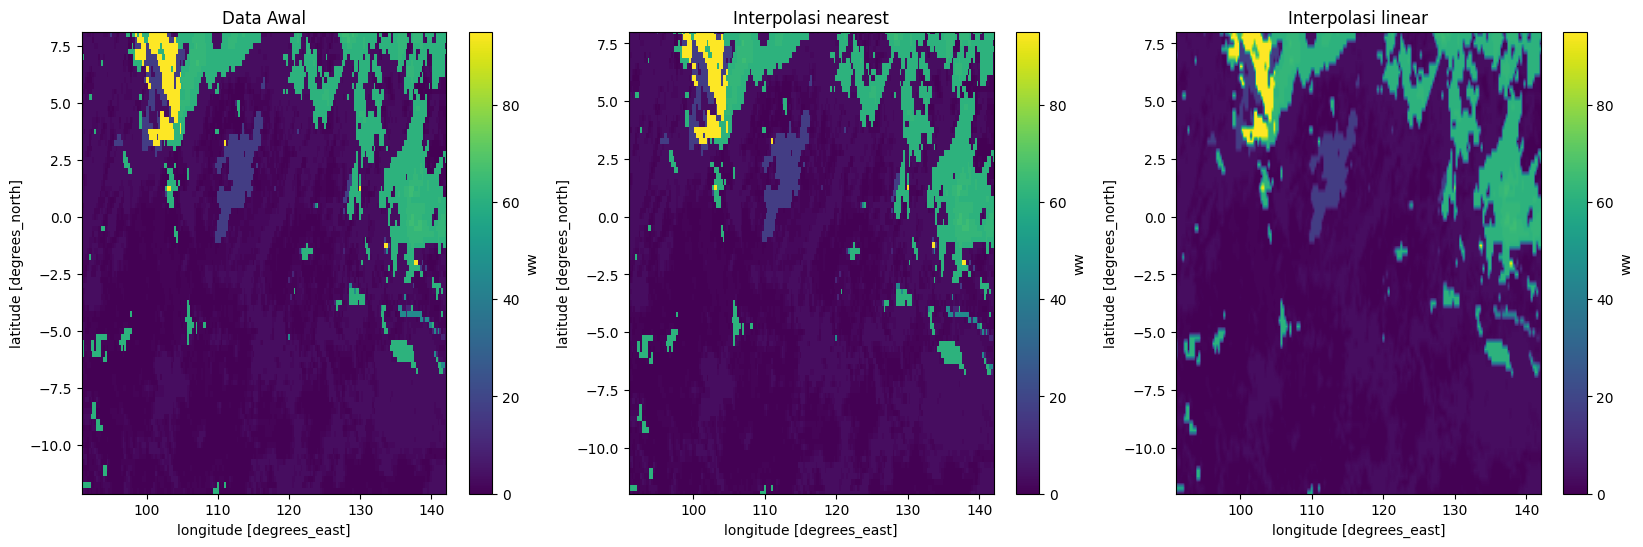

In [12]:
#Cek plot data dan compare
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
ds_sw['ww'].plot()
plt.title('Data Awal')

plt.subplot(1,3,2)
sw_interp.plot()
plt.title('Interpolasi nearest')

plt.subplot(1,3,3)
sw_interp_linear.plot()
plt.title('Interpolasi linear')

plt.show()

Jika data RH500, TTI, KI, tp, vis, dan tcc di interpolasi terlebih dahulu

In [14]:
#Interpolasi tsi, tp, vis, dan tcc
dstsi_interp = dstsi.interp(longitude=new_lon, latitude=new_lat, method='linear')
tp_interp = tp.interp(longitude=new_lon, latitude=new_lat, method='linear')
vis_interp = vis.interp(longitude=new_lon, latitude=new_lat, method='linear')
tcc_interp = tcc.interp(longitude=new_lon, latitude=new_lat, method='linear')

In [15]:
tsi_grid = np.full(dstsi_interp['t'][0].shape, 0)
TSI_interp = tsi(tsi_grid,dstsi_interp)

In [18]:
#Evaluasi TSI
tsi_grid = np.full(dstsi_interp['t'][0].shape, 0)
TSI_interp = tsi(tsi_grid,dstsi_interp)

#Evaluasi SW
sw_grid = np.full(dstsi_interp['t'][0].shape, 0)
sw_interp2 = sw(sw_grid,TSI_interp,tp_interp,vis_interp,tcc_interp)

#Ubah SW ke Dataset
ds_sw_interp2 = xr.Dataset(
    {
        'ww': (['latitude', 'longitude'], sw_interp2),
        'tsi': (['latitude', 'longitude'], TSI_interp),
        'tp': (['latitude', 'longitude'], tp_interp.values),
        'vis': (['latitude', 'longitude'], vis_interp.values),
        'tcc': (['latitude', 'longitude'], tcc_interp.values)
    },
    coords={
        'latitude': dsinterp['latitude'],
        'longitude': dsinterp['longitude']
    }
)

In [19]:
ds_sw_interp2

<xarray.Dataset> Size: 65MB
Dimensions:     (latitude: 800, longitude: 2040)
Coordinates:
    time        datetime64[ns] 8B 2024-07-14T12:00:00
    step        timedelta64[ns] 8B 04:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 6kB 8.0 7.975 7.95 ... -11.93 -11.95 -11.97
    valid_time  datetime64[ns] 8B 2024-07-14T16:00:00
  * longitude   (longitude) float64 16kB 91.0 91.03 91.05 ... 141.9 142.0 142.0
Data variables:
    ww          (latitude, longitude) int64 13MB 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3
    tsi         (latitude, longitude) int64 13MB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    tp          (latitude, longitude) float64 13MB 0.0625 0.075 ... 0.0 0.0
    vis         (latitude, longitude) float64 13MB 2.414e+04 ... 2.414e+04
    tcc         (latitude, longitude) float64 13MB 100.0 100.0 ... 99.93 99.92

Compare dengan 2 plot sebelumnya

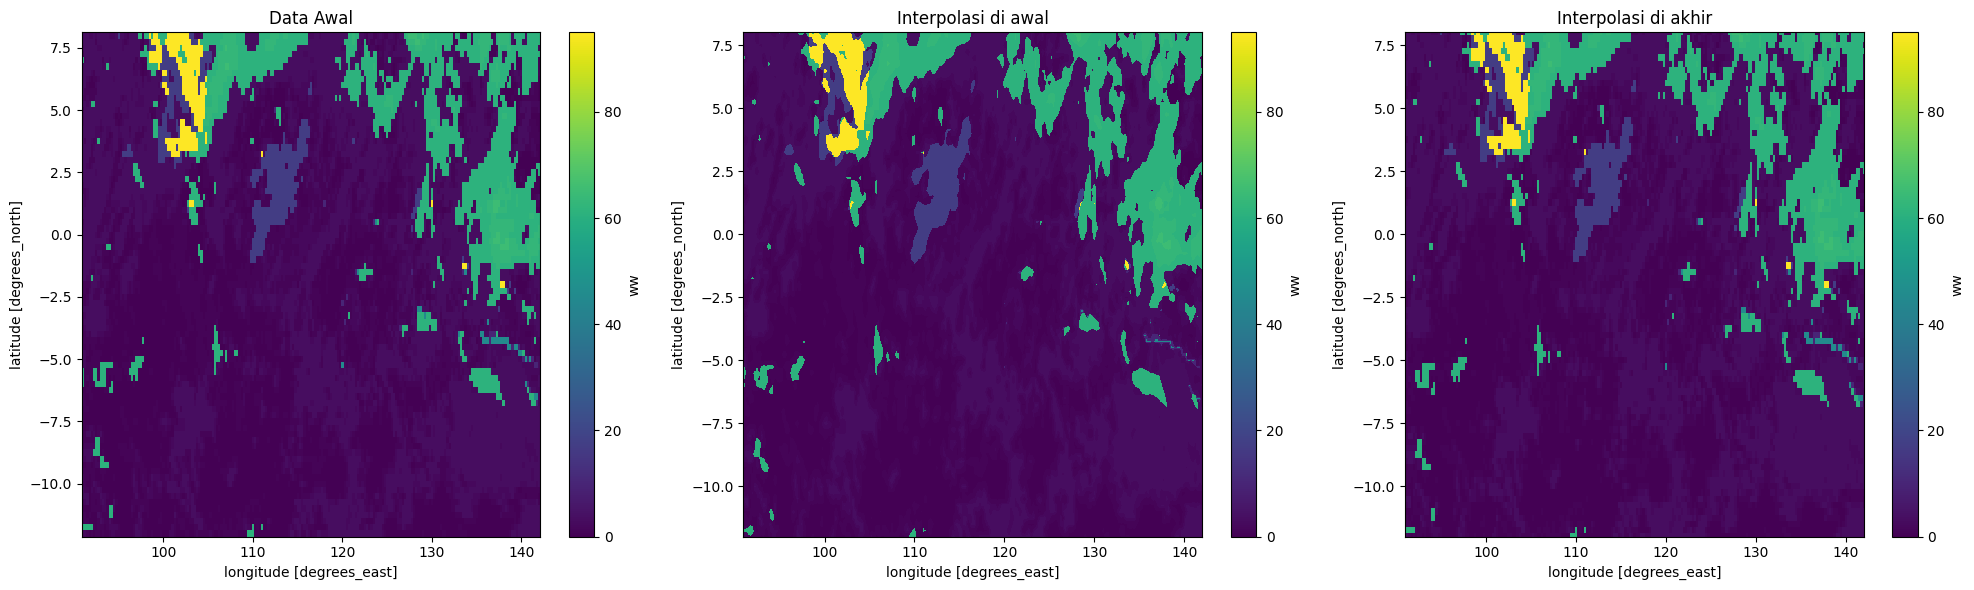

In [20]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
ds_sw['ww'].plot()
plt.title('Data Awal')

plt.subplot(1,3,2)
ds_sw_interp2['ww'].plot()
plt.title('Interpolasi di awal')

plt.subplot(1,3,3)
sw_interp.plot()
plt.title('Interpolasi di akhir')

plt.tight_layout()
plt.show()